# Example 10.19

Apply **Milne’s method** to solve the differential equation $dy/dx = x - y^2$ in the range $0 < x \le 1$, with the initial condition $y(0) = 0$

Adam Iter 0, Loss 3.899e-01
Adam Iter 1000, Loss 2.420e-05
Adam Iter 2000, Loss 3.264e-06
Adam Iter 3000, Loss 1.238e-07
Adam Iter 4000, Loss 4.081e-06
Adam Iter 5000, Loss 1.368e-07
Adam Iter 6000, Loss 5.018e-08
Adam Iter 7000, Loss 6.063e-08
Adam Iter 8000, Loss 1.023e-04
Adam Iter 9000, Loss 4.921e-07
x=0.0, Scipy= 0.000000, Milne=0.000000, PINN=-0.000003
x=0.2, Scipy= 0.019973, Milne=0.019980, PINN=0.019958
x=0.4, Scipy= 0.079493, Milne=0.079484, PINN=0.079515
x=0.6, Scipy= 0.176219, Milne=0.176204, PINN=0.176197
x=0.8, Scipy= 0.304598, Milne=0.304599, PINN=0.304586
x=1.0, Scipy= 0.455542, Milne=0.455556, PINN=0.455549


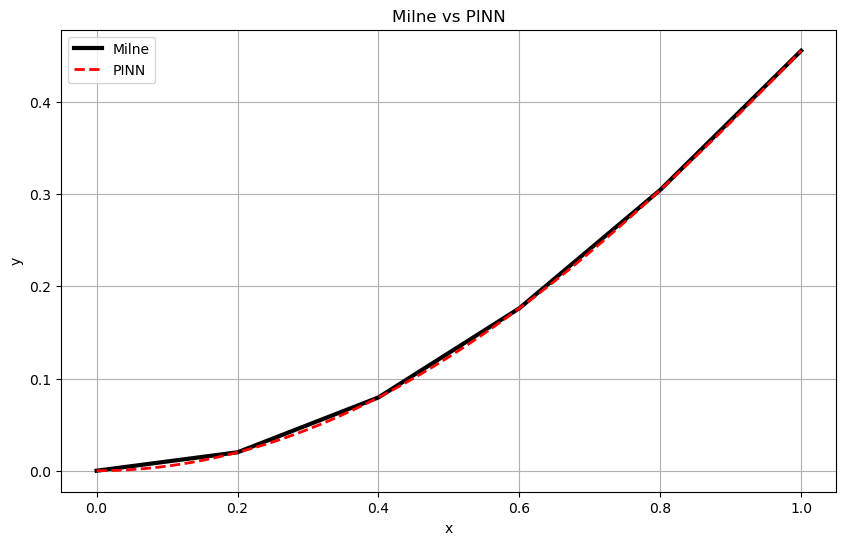

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from scipy import integrate
import matplotlib.pyplot as plt

# =============================
# 1. Scipy
# =============================
def f(x, y):
    return x - y**2

x_vals = np.linspace(0, 1, 6)

scipy = integrate.solve_ivp(f, (0, 1), [0], method='RK45', t_eval=x_vals)
# =============================
# 2. Milne Method
# =============================
def rk4(f, x0, y0, n):
    xs = [x0]
    ys = [y0]
    x = x0
    y = y0

    for i in range(n):
        k1 = h * f(x, y)
        k2 = h * f(x + h/2, y + k1/2)
        k3 = h * f(x + h/2, y + k2/2)
        k4 = h * f(x + h, y + k3)
        y = y + (k1 + 2*k2 + 2*k3 + k4) / 6
        x = x + h
        xs.append(x)
        ys.append(y)
    return xs, ys
h = 0.2
xs, ys = rk4(f, 0, 0, 3)

tol = 1e-6
for i in range(3, 5):
    yp = ys[i-3] + (4*h/3)*(2*f(xs[i-2], ys[i-2]) - f(xs[i-1], ys[i-1]) + 2*f(xs[i], ys[i]))
    x = xs[i] + h
    yc = ys[i-1] + (h/3)*(f(xs[i-1], ys[i-1]) + 4*f(xs[i], ys[i]) + f(x, yp))
    while True:
        yc_new = ys[i-1] + (h/3)*(f(xs[i-1], ys[i-1]) + 4*f(xs[i], ys[i]) + f(x, yc))
        if abs(yc_new - yc) < tol:
            break
        yc = yc_new
    xs.append(x)
    ys.append(yc)

# ================================
# 3. PINN
# ================================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        return self.net(x)
model = PINN().to(device)

x_colloc = torch.linspace(0, 1, 200, dtype=torch.float32, device=device, requires_grad=True).reshape(-1, 1)

x0 = torch.tensor([0.0], dtype=torch.float32, device=device)
y0 = torch.tensor([0.0], dtype=torch.float32, device=device)

def pinn_loss():
    y_pred = model(x_colloc)
    dy = torch.autograd.grad(y_pred, x_colloc, grad_outputs=torch.ones_like(y_pred), create_graph=True)[0]
    f = dy - x_colloc + y_pred**2
    loss_pde = torch.mean(f**2)
    y0_pred = model(x0)
    loss_ic = torch.mean((y0 - y0_pred)**2)
    return loss_pde + loss_ic

optimizer_adam = optim.Adam(model.parameters(), lr=5e-4)

for it in range(10000):
    optimizer_adam.zero_grad()
    loss = pinn_loss()
    loss.backward()
    optimizer_adam.step()
    if it % 1000 == 0:
        print(f'Adam Iter {it}, Loss {loss.item():.3e}')

optimizer_lbfgs = optim.LBFGS(model.parameters(), lr=1.0, max_iter=500, line_search_fn='strong_wolfe')

def closure():
    optimizer_lbfgs.zero_grad()
    loss = pinn_loss()
    loss.backward()
    return loss
optimizer_lbfgs.step(closure)

x_pinn = torch.linspace(0, 1, 6, dtype=torch.float32, device=device).reshape(-1, 1)
y_pinn = model(x_pinn).detach().numpy().flatten()

for xi, yi, zi, pi in zip(xs, scipy.y[0], ys, y_pinn):
    print(f'x={xi:.1f}, Scipy= {yi:.6f}, Milne={zi:.6f}, PINN={pi:.6f}')
# ================================
# 4. Plot
# ================================
x_pinn_plot = torch.linspace(0, 1, 200, dtype=torch.float32, device=device).reshape(-1, 1)
y_pinn_plot = model(x_pinn_plot).detach().numpy()
plt.figure(figsize=(10, 6))
plt.plot(xs, ys, 'k-', label='Milne', linewidth=3)
plt.plot(x_pinn_plot, y_pinn_plot, 'r--', label='PINN', linewidth=2)
plt.title('Milne vs PINN')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.legend()
plt.show()

# EXAMPLE 10.20

Using Milne’s method find $y(4.5)$ given $5xy' + y^2 - 2 = 0$ with initial values $y(4) = 1$, $y(4.1) = 1.0049$, $y(4.2) = 1.0097$, $y(4.3) = 1.0143$, $y(4.4) = 1.0187$

Adam Iter 0, Loss 9.636e-01
Adam Iter 1000, Loss 4.412e-07
Adam Iter 2000, Loss 3.639e-07
Adam Iter 3000, Loss 2.583e-07
Adam Iter 4000, Loss 1.451e-07
Adam Iter 5000, Loss 5.584e-08
Adam Iter 6000, Loss 1.158e-08
Adam Iter 7000, Loss 7.310e-09
Adam Iter 8000, Loss 1.229e-04
Adam Iter 9000, Loss 3.638e-09
x=4.0, scipy=1.000000, Milne=1.000000, PINN=0.999996
x=4.1, scipy=1.004914, Milne=1.004914, PINN=1.00491
x=4.2, scipy=1.009663, Milne=1.009663, PINN=1.00967
x=4.3, scipy=1.014256, Milne=1.014256, PINN=1.01426
x=4.4, scipy=1.018701, Milne=1.018701, PINN=1.0187
x=4.5, scipy=1.023006, Milne=1.023006, PINN=1.023


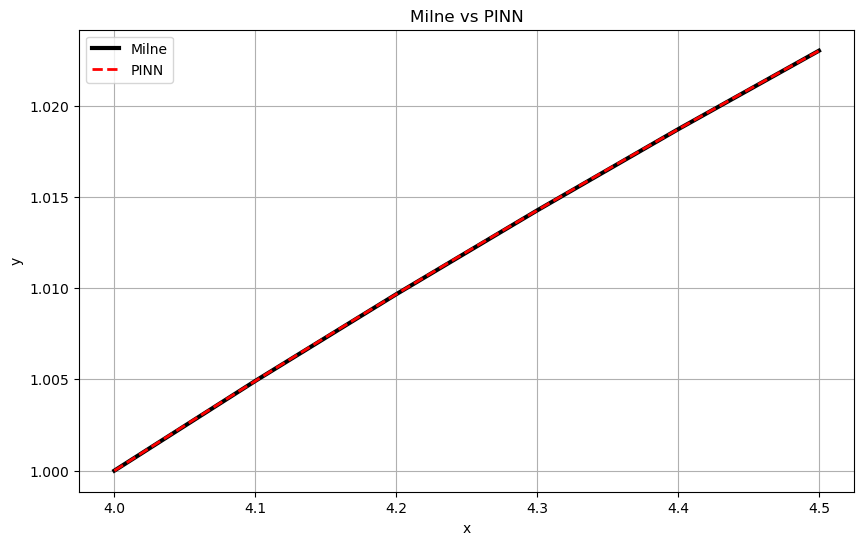

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from scipy import integrate
import matplotlib.pyplot as plt
# ===============================
# 1. Scipy
# ===============================
def f(x, y):
    return (2 - y**2) / (5*x)
scipy = integrate.solve_ivp(f, (4, 4.5), [1], method='RK45', t_eval=np.linspace(4, 4.5, 6))
# ===============================
# 2. Milne Method
# ===============================
def rk4(f, x0, y0, h, n):
    xs = [x0]
    ys = [y0]
    x = x0
    y = y0

    for i in range(n):
        k1 = h * f(x, y)
        k2 = h * f(x + h/2, y + k1/2)
        k3 = h * f(x + h/2, y + k2/2)
        k4 = h * f(x + h, y + k3)
        y = y + (k1 + 2*k2 + 2*k3 + k4) / 6
        x = x + h
        xs.append(x)
        ys.append(y)
    return xs, ys
xs, ys = rk4(f, 4, 1, 0.1, 4)
h = 0.1
tol = 1e-6
for i in range(4, 5):
    yp = ys[i-3] + (4*h/3)*(2*f(xs[i], ys[i]) - f(xs[i-1], ys[i-1]) + 2*f(xs[i-2], ys[i-2]))
    x = xs[i] + h
    yc = ys[i-1] + (h/3)*(f(xs[i-1], ys[i-1]) + 4*f(xs[i], ys[i]) + f(x, yp))
    while True:
        yc_new =ys[i-1] + (h/3)*(f(xs[i-1], ys[i-1]) + 4*f(xs[i], ys[i]) + f(x, yc))
        if abs(yc - yc_new) < tol:
            break
        yc = yc_new
    xs.append(x)
    ys.append(yc)
# ================================
# 3. PINN
# ================================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        return self.net(x)
model = PINN().to(device)

x_colloc = torch.linspace(4, 4.5, 200, dtype=torch.float32, device=device, requires_grad=True).reshape(-1, 1)

x0 = torch.tensor([4.0], dtype=torch.float32, device=device)
y0 = torch.tensor([1.0], dtype=torch.float32, device=device)

def pinn_loss():
    y_pred = model(x_colloc)
    dy = torch.autograd.grad(y_pred, x_colloc, grad_outputs=torch.ones_like(y_pred), create_graph=True)[0]
    f = dy -(2 - y_pred**2) / (5*x_colloc)
    loss_pde = torch.mean(f**2)
    y0_pred = model(x0)
    loss_ic = torch.mean((y0 - y0_pred)**2)
    return loss_pde + loss_ic

optimizer_adam = optim.Adam(model.parameters(), lr=5e-4)

for it in range(10000):
    optimizer_adam.zero_grad()
    loss = pinn_loss()
    loss.backward()
    optimizer_adam.step()
    if it % 1000 == 0:
        print(f'Adam Iter {it}, Loss {loss.item():.3e}')

optimizer_lbfgs = optim.LBFGS(model.parameters(), lr=1.0, max_iter=500, line_search_fn='strong_wolfe')

def closure():
    optimizer_lbfgs.zero_grad()
    loss = pinn_loss()
    loss.backward()
    return loss
optimizer_lbfgs.step(closure)

x_pinn = torch.linspace(4, 4.5, 6, dtype=torch.float32, device=device).reshape(-1, 1)
y_pinn = model(x_pinn).detach().numpy().flatten()
for xi, yi, zi, pi in zip(xs, scipy.y[0], ys, y_pinn):
    print(f'x={xi:.1f}, scipy={yi:.6f}, Milne={zi:.6f}, PINN={pi:.6}')
# =============================
# 4. Plot
# =============================
x_pinn_plot = torch.linspace(4, 4.5, 200, dtype=torch.float32, device=device).reshape(-1, 1)
y_pinn_plot = model(x_pinn_plot).detach().numpy()
plt.figure(figsize=(10, 6))
plt.plot(xs, ys, 'k-', label='Milne', linewidth=3)
plt.plot(x_pinn_plot, y_pinn_plot, 'r--', label='PINN', linewidth=2)
plt.title('Milne vs PINN')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.legend()
plt.show()

# EXAMPLE 10.21

Given $y' = x(x^2 + y^2) e^{-x}$, $y(0) = 1$, find $y$ at $x = 0.1$, $0.2$, and $0.3$ by Taylor’s series method and compute $y(0.4)$ by Milne’s method

In [ ]:
import sympy as sp

x = sp.Symbol('x')
y = sp.Function('y')(x)
f= x*(x**2 + y**2)*sp.exp(-x)

def taylor_series(f, x0, y0, n):
    der = [y0]
    y1 = f.subs({x: x0, y: y0})
    der.append(y1)

    current = f

    for k in range(2, n):
        current = sp.diff(current, x)

        subs_dic = {x: x0, y: y0}
        for i in range(1, k):
            subs_dic[sp.diff(y, x, i)] = der[i]
        val = current.subs(subs_dic)
        der.append(val)

    T = 0
    for k in range(n):
        T += der[k]*(x-x0)**k / sp.factorial(k)
    return T, der
T, der = taylor_series(f, 0, 1, 3)
x0 = 0
y0 = 1
h = 0.1
xs = [x0]
ys = [y0]
for i in range(3):
    x_new = xs[i] + h
    xs.append(x_new)
    ys.append(T.subs(x, x_new))
tol = 1e-6
def f(x, y):
    return x*(x**2 + y**2)*sp.exp(-x)
for i in range(3, 4):
    yp = ys[i-3] + (4*h/3)*(2*f(xs[i], ys[i]) - f(xs[i-1], ys[i-1]) + 2*f(xs[i-2], ys[i-2]))
    x_next = xs[i] + h
    yc = ys[i-1] + (h/3)*(f(xs[i-1], ys[i-1]) + 4*f(xs[i], ys[i]) +f(x_next, yp))
    while True:
        yc_new = ys[i-1] +(h/3)*(f(xs[i-1], ys[i-1]) + 4*f(xs[i], ys[i]) + f(x_next, yc))
        if abs(yc_new - yc) < tol:
            break
        yc = yc_new
    xs.append(x_next)
    ys.append(yc)
for xi, yi in zip(xs, ys):
    print(f'x = {xi:.1f}, y = {yi:.6f}')

x = 0.0, y = 1.000000
x = 0.1, y = 1.005000
x = 0.2, y = 1.020000
x = 0.3, y = 1.045000
x = 0.4, y = 1.072636


# EXAMPLE 10.22

Using the Runge–Kutta method of order 4, find $y$ for $x = 0.1,,0.2,,0.3$ given that $\dfrac{dy}{dx} = x y + y^{2},; y(0) = 1$. Continue the solution at $x = 0.4$ using Milne’s method.

Adam Iter 0, Loss=4.312e-01
Adam Iter 1000, Loss=1.945e-04
Adam Iter 2000, Loss=5.426e-05
Adam Iter 3000, Loss=1.304e-05
Adam Iter 4000, Loss=7.114e-06
Adam Iter 5000, Loss=2.803e-04
Adam Iter 6000, Loss=2.382e-06
Adam Iter 7000, Loss=1.960e-06
Adam Iter 8000, Loss=1.706e-06
Adam Iter 9000, Loss=2.869e-04
x=0.0, Scipy=1.000000, Milne=1.000000, PINN=0.999961
x=0.1, Scipy=1.116968, Milne=1.116887, PINN=1.116818
x=0.2, Scipy=1.277928, Milne=1.277391, PINN=1.277362
x=0.3, Scipy=1.503709, Milne=1.504119, PINN=1.504001
x=0.4, Scipy=1.838997, Milne=1.839421, PINN=1.838846


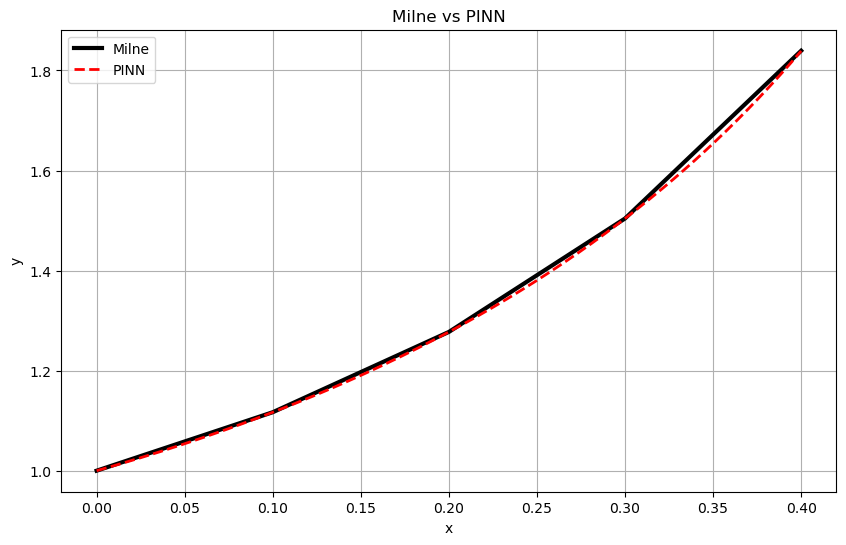

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from scipy import integrate
import matplotlib.pyplot as plt
# ==============================
# 1. Scipy
# ==============================
def f(x, y):
    return x*y + y**2
scipy = integrate.solve_ivp(f, (0, 0.4), [1], method='RK45', t_eval=np.linspace(0, 0.4, 5))
# ==============================
# 2. Milne Method
# ==============================
def rk4(f, x0, y0, h, n):
    xs = [x0]
    ys = [y0]
    x = x0
    y = y0
    
    for i in range(n):
        k1 = h * f(x, y)
        k2 = h * f(x + h/2, y + k1/2)
        k3 = h * f(x + h/2, y + k2/2)
        k4 = h * f(x + h, y + k3)
        y = y + (k1 + 2*k2 + 2*k3 + k4) / 6
        x = x + h
        xs.append(x)
        ys.append(y)
    return xs, ys
xs, ys = rk4(f, 0, 1, 0.1, 3)

tol = 1e-6
for i in range(3, 4):
    yp = ys[i-3] + (4*h/3)*(2*f(xs[i], ys[i]) - f(xs[i-1], ys[i-1]) + 2*f(xs[i-2], ys[i-2]))
    x_next = xs[i] + h
    yc = ys[i-1] + (h/3)*(f(xs[i-1], ys[i-1]) +4*f(xs[i], ys[i]) + f(x_next, yp))
    while True:
        yc_new = ys[i-1] + (h/3)*(f(xs[i-1], ys[i-1]) + 4*f(xs[i], ys[i]) + f(x_next, yc))
        if abs(yc_new - yc) < tol:
            break
        yc = yc_new
    xs.append(x_next)
    ys.append(yc)
# ==============================
# 3. PINN
# ==============================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        return self.net(x)

model = PINN().to(device)

x_colloc = torch.linspace(0, 0.4, 200, dtype=torch.float32, device=device, requires_grad=True).reshape(-1, 1)
x0 = torch.tensor([0.0], dtype=torch.float32, device=device)
y0 = torch.tensor([1.0], dtype=torch.float32, device=device)

def pinn_loss():
    y_pred = model(x_colloc)
    dy = torch.autograd.grad(y_pred, x_colloc, grad_outputs=torch.ones_like(y_pred), create_graph=True)[0]
    f = dy - x_colloc*y_pred - y_pred**2
    loss_pde = torch.mean(f**2)
    loss_ic = torch.mean((y0 - model(x0))**2)
    return loss_pde + loss_ic

optimizer_adam = optim.Adam(model.parameters(), lr=5e-4)
for it in range(10000):
    optimizer_adam.zero_grad()
    loss = pinn_loss()
    loss.backward()
    optimizer_adam.step()
    if it % 1000 == 0:
        print(f'Adam Iter {it}, Loss={loss.item():.3e}')

optimizer_lbfgs = optim.LBFGS(model.parameters(), lr=1.0, max_iter=500, line_search_fn='strong_wolfe')
def closure():
    optimizer_lbfgs.zero_grad()
    loss = pinn_loss()
    loss.backward()
    return loss
optimizer_lbfgs.step(closure)

x_pinn = torch.linspace(0, 0.4, 5, dtype=torch.float32, device=device).reshape(-1, 1)
y_pinn = model(x_pinn).detach().numpy().flatten()
for xi, yi, zi, pi in zip(xs, scipy.y[0], ys, y_pinn):
    print(f'x={xi:.1f}, Scipy={yi:.6f}, Milne={zi:.6f}, PINN={pi:.6f}')
# ====================================
# 4. Plot
# ====================================
x_pinn_plot = torch.linspace(0, 0.4, 200, dtype=torch.float32, device=device).reshape(-1, 1)
y_pinn_plot = model(x_pinn_plot).detach().numpy()
plt.figure(figsize=(10, 6))
plt.plot(xs, ys, 'k-', label='Milne', linewidth=3)
plt.plot(x_pinn_plot, y_pinn_plot, 'r--', label='PINN', linewidth=2)
plt.title('Milne vs PINN')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.legend()
plt.show()

# Exercise 10.4

1. Given $\dfrac{dy}{dx} = x^3 + y$, $y(0) = 2$. The values of $y(0.2) = 2.073$, $y(0.4) = 2.452$, and $y(0.6) = 3.023$ are obtained by the R.K. method of the order. Find $y(0.8)$ by Milne’s predictor-corrector method taking $h = 0.2$.
2. Given $\dfrac{dy}{dx} = (1 + x^2) y^2$, $y(0) = 1$, $y(0.1) = 1.06$, $y(0.2) = 1.12$, $y(0.3) = 1.21$, evaluate $y(0.4)$ by Milne’s predictor-corrector method.

3. Solve the initial value problem $\dfrac{dy}{dx} = x y^2 + 1$, $y(0) = 1$ for $x = 0.4$ by using Milne’s method, when it is given that: $x$: 0.1, 0.2, 0.3  
$y$: 1.105, 1.223, 1.35

4. From the data given below, find $y$ at $x = 1.4$ using Milne’s predictor–corrector formula for $ \dfrac{dy}{dx} = x^{2} + \dfrac{y}{2} $: $x: 1,\; 1.1,\; 1.2,\; 1.3$  $y: 2,\; 2.2156,\; 2.4549,\; 2.7514$

5. Using Taylor’s series method, solve $ \dfrac{dy}{dx} = x y + x^2 $, $y(0) = 1$ at $x = 0.1,\; 0.2,\; 0.3$. Continue the solution at $x = 0.4$ by Milne’s predictor–corrector method.

6. If $ \dfrac{dy}{dx} = 2 e^{x} - y $, $y(0) = 2$, $y(0.1) = 2.01$, $y(0.2) = 2.04$, and $y(0.3) = 2.09$, find $y(0.4)$ using Milne’s predictor–corrector method.

7. Using the Runge–Kutta method, calculate $y(0.1)$, $y(0.2)$, and $y(0.3)$ given that $ \dfrac{dy}{dx} = \dfrac{2xy}{1+x^2} + 1 $, $y(0) = 0$. Taking these values as starting values, find $y(0.4)$ by Milne’s method.

# 1

In [45]:
def f(x, y):
    return x**3 + y

def rk4(f, x0, y0, h, n):
    xs = [x0]
    ys = [y0]
    x = x0
    y = y0

    for i in range(n):
        k1 = h * f(x, y)
        k2 = h * f(x + h/2, y + k1/2)
        k3 = h * f(x + h/2, y + k2/2)
        k4 = h * f(x + h, y + k3)
        y = y + (k1 + 2*k2 + 2*k3 + k4) / 6
        x = x + h
        xs.append(x)
        ys.append(y)
    return xs, ys
xs, ys = rk4(f, 0, 2, 0.2, 3)
x0 = 0
y0 = 2
h = 0.2
tol = 1e-4
for i in range(3, 4):
    yp = ys[i-3] + (4*h/3)*(2*f(xs[i], ys[i]) - f(xs[i-1], ys[i-1]) + 2*f(xs[i-2], ys[i-2]))
    x_next = xs[i] + h
    yc = ys[i-1] + (h/3)*(f(xs[i-1], ys[i-1]) + 4*f(xs[i], ys[i]) + f(x_next, yp))
    while True:
        yc_new = ys[i-1] + (h/3)*(f(xs[i-1], ys[i-1]) + 4*f(xs[i], ys[i]) + f(x_next, yc))
        if abs(yc_new - yc) < tol:
            break
        yc = yc_new
    xs.append(x_next)
    ys.append(yc)
for xi, yi in zip(xs, ys):
    print(f'x = {xi:.1f}, y = {yi:.4f}')

x = 0.0, y = 2.0000
x = 0.2, y = 2.4432
x = 0.4, y = 2.9906
x = 0.6, y = 3.6809
x = 0.8, y = 4.5723


# 2

In [5]:
def f(x, y):
    return (1 + x**2)*y**2 / 2

def rk4(f, x0, y0, h, n):
    xs = [x0]
    ys = [y0]
    x = x0
    y = y0

    for i in range(n):
        k1 = h * f(x, y)
        k2 = h * f(x + h/2, y + k1/2)
        k3 = h * f(x + h/2, y + k2/2)
        k4 = h * f(x + h, y + k3)
        y = y + (k1 + 2*k2 + 2*k3 + k4) / 6
        x = x + h
        xs.append(x)
        ys.append(y)
    return xs, ys
xs, ys = rk4(f, 0, 1, 0.1, 3)

h = 0.1
tol = 1e-6
for i in range(3, 4):
    yp = ys[i-3] + (4*h/3)*(2*f(xs[i], ys[i]) - f(xs[i-1], ys[i-1]) + 2*f(xs[i-2], ys[i-2]))
    x_next = xs[i] + h
    yc = ys[i-1] + (h/3)*(f(xs[i-1], ys[i-1]) + 4*f(xs[i], ys[i]) + f(x_next, yp))
    while True:
        yc_new = ys[i-1] + (h/3)*(f(xs[i-1], ys[i-1]) + 4*f(xs[i], ys[i]) +f(x_next, yc))
        if abs(yc_new - yc) < tol:
            break
        yc = yc_new
    xs.append(x_next)
    ys.append(yc)
for xi, yi in zip(xs, ys):
    print(f'x = {xi:.1f}, y = {yi:.6f}')

x = 0.0, y = 1.000000
x = 0.1, y = 1.052816
x = 0.2, y = 1.112760
x = 0.3, y = 1.182732
x = 0.4, y = 1.266903


# 3

In [6]:
def f(x, y):
    return x*y + 1

def rk4(f, x0, y0, h, n):
    xs = [x0]
    ys = [y0]
    x = x0
    y = y0

    for i in range(n):
        k1 = h * f(x, y)
        k2 = h * f(x + h/2, y + k1/2)
        k3 = h * f(x + h/2, y + k2/2)
        k4 = h * f(x + h, y + k3)
        y = y + (k1 + 2*k2 + 2*k3 + k4) / 6
        x = x + h
        xs.append(x)
        ys.append(y)
    return xs, ys
xs, ys = rk4(f, 0, 1, 0.1, 3)

h = 0.1
tol = 1e-6
for i in range(3, 4):
    yp = ys[i-3] + (4*h/3)*(2*f(xs[i], ys[i]) - f(xs[i-1], ys[i-1]) + 2*f(xs[i-2], ys[i-2]))
    x_next = xs[i] + h
    yc = ys[i-1] + (h/3)*(f(xs[i-1], ys[i-1]) + 4*f(xs[i], ys[i]) + f(x_next, yp))
    while True:
        yc_new = ys[i-1] + (h/3)*(f(xs[i-1], ys[i-1]) + 4*f(xs[i], ys[i]) + f(x_next, yc))
        if abs(yc_new - yc) < tol:
            break
        yc = yc_new
    xs.append(x_next)
    ys.append(yc)
for xi, yi in zip(xs, ys):
    print(f'x = {xi:.1f}, y = {yi:.6f}')

x = 0.0, y = 1.000000
x = 0.1, y = 1.105346
x = 0.2, y = 1.222889
x = 0.3, y = 1.355192
x = 0.4, y = 1.505320


# 4

In [9]:
def f(x, y):
    return x**2 + y/2

def rk4(f, x0, y0, h, n):
    xs = [x0]
    ys = [y0]
    x = x0
    y = y0

    for i in range(n):
        k1 = h * f(x, y)
        k2 = h * f(x + h/2, y + k1/2)
        k3 = h * f(x + h/2, y + k2/2)
        k4 = h * f(x + h, y + k3)
        y = y + (k1 + 2*k2 + 2*k3 + k4) / 6
        x = x + h
        xs.append(x)
        ys.append(y)
    return xs, ys
xs, ys = rk4(f, 1, 2, 0.1, 3)

h = 0.1
tol = 1e-6
for i in range(3, 4):
    yp = ys[i-3] + (4*h/3)*(2*f(xs[i], ys[i]) - f(xs[i-1], ys[i-1]) + 2*f(xs[i-2], ys[i-2]))
    x_next = xs[i] + h
    yc = ys[i-1] + (h/3)*(f(xs[i-1], ys[i-1]) + 4*f(xs[i], ys[i]) + f(x_next, yp))
    while True:
        yc_new = ys[i-1] + (h/3)*(f(xs[i-1], ys[i-1]) + 4*f(xs[i], ys[i]) + f(x_next, yc))
        if abs(yc_new - yc):
            break
        yc = yc_new
    xs.append(x_next)
    ys.append(yc)
for xi, yi in zip(xs, ys):
    print(f'x = {xi:.1f}, y = {yi:.6f}')

x = 1.0, y = 2.000000
x = 1.1, y = 2.215591
x = 1.2, y = 2.464786
x = 1.3, y = 2.751359
x = 1.4, y = 3.079277


# 5

In [25]:
import sympy as sp

x = sp.Symbol('x')
y = sp.Function('y')(x)

f = x*y + x**2

def taylor_series(f, x0, y0, n):
    der = [y0]
    y1 = f.subs({x: x0, y: y0})
    der.append(y1)
    current = f
    for k in range(2, n):
        current = sp.diff(current, x)
        subs_dic = {x: x0,  y: y0}
        for i in range(1, k):
            subs_dic[sp.diff(y, x, i)] = der[i]

        val = current.subs(subs_dic)
        der.append(val)
    T = 0
    for k in range(n):
        T += der[k] * (x -x0)**k / sp.factorial(k)
    return T, der
T, der = taylor_series(f, 0, 1, 8)
def f(x, y):
    return x*y + x**2

h = 0.1
tol = 1e-6
xs = [0, 0.1, 0.2, 0.3]
ys = [1]
for i in range(1, 4):
    ys.append(T.subs(x, xs[i]))
for i in range(3, 4):
    yp = ys[i-3] + (4*h/3)*(2*f(xs[i], ys[i]) - f(xs[i-1], ys[i-1]) + 2*f(xs[i-2], ys[i-2]))
    x_next = xs[i] + h
    yc = ys[i-1] + (h/3)*(f(xs[i-1], ys[i-1]) + 4*f(xs[i], ys[i]) + f(x_next, yp))
    while True:
        yc_next = ys[i-1] + (h/3)*(f(xs[i-1], ys[i-1]) + 4*f(xs[i], ys[i]) + f(x_next, yc))
        if abs(yc_next - yc) < tol:
            break
        yc = yc_next
    xs.append(x_next)
    ys.append(yc)
for xi, yi in zip(xs, ys):
    print(f'x = {xi:.1f}, y = {yi:.6f}')

x = 0.0, y = 1.000000
x = 0.1, y = 1.005347
x = 0.2, y = 1.022889
x = 0.3, y = 1.055192
x = 0.4, y = 1.105320


# 6

In [27]:
import math
def f(x, y):
    return 2*math.exp(x) - y

def rk4(f, x0, y0, h, n):
    xs = [x0]
    ys = [y0]
    x = x0
    y = y0

    for i in range(n):
        k1 = h * f(x, y)
        k2 = h * f(x + h/2, y + k1/2)
        k3 = h * f(x + h/2, y + k2/2)
        k4 = h * f(x + h, y + k3)
        y = y + (k1 + 2*k2 + 2*k3 + k4) / 6
        x = x + h
        xs.append(x)
        ys.append(y)
    return xs, ys
xs, ys = rk4(f, 0, 2, 0.1, 3)


h = 0.1
tol = 1e-6
for i in range(3, 4):
    yp = ys[i-3] + (4*h/3)*(2*f(xs[i], ys[i]) - f(xs[i-1], ys[i-1]) + 2*f(xs[i-2], ys[i-2]))
    x_next = xs[i] + h
    yc = ys[i-1] + (h/3)*(f(xs[i-1], ys[i-1]) + 4*f(xs[i], ys[i]) + f(x_next, yp))
    while True:
        yc_next = ys[i-1] + (h/3)*(f(xs[i-1], ys[i-1]) + 4*f(xs[i], ys[i]) + f(x_next, yc))
        if abs(yc_next - yc) < tol:
            break
        yc = yc_next
    xs.append(x_next)
    ys.append(yc)
for xi, yi in zip(xs, ys):
    print(f'x = {xi:.1f}, y = {yi:.6f}')

x = 0.0, y = 2.000000
x = 0.1, y = 2.010009
x = 0.2, y = 2.040134
x = 0.3, y = 2.090678
x = 0.4, y = 2.162145


# 7

In [30]:
def f(x, y):
    return ((2*x*y) / (1 + x**2)) + 1

def rk4(f, x0, y0, h, n):
    xs = [x0]
    ys = [y0]
    x = x0
    y = y0

    for i in range(n):
        k1 = h * f(x, y)
        k2 = h * f(x + h/2, y + k1/2)
        k3 = h * f(x + h/2, y + k2/2)
        k4 = h * f(x + h, y + k3)
        y = y + (k1 + 2*k2 + 2*k3 + k4) / 6
        x = x + h
        xs.append(x)
        ys.append(y)
    return xs, ys
xs, ys = rk4(f, 0, 0, 0.1, 3)

h = 0.1
tol = 1e-6

for i in range(3, 4):
    yp = ys[i-3] + (4*h/3)*(2*f(xs[i], ys[i]) - f(xs[i-1], ys[i-1]) + 2*f(xs[i-2], ys[i-2]))
    x_next = xs[i] + h
    yc = ys[i-1] + (h/3)*(f(xs[i-1], ys[i-1]) + 4*f(xs[i], ys[i]) + f(x_next, yp))
    while True:
        yc_new = ys[i-1] + (h/3)*(f(xs[i-1], ys[i-1]) + 4*f(xs[i], ys[i]) + f(x_next, yc))
        if abs(yc_new - yc) < tol:
            break
        yc = yc_new
    xs.append(x_next)
    ys.append(yc)
for xi, yi in zip(xs, ys):
    print(f'x = {xi:.1f}, y = {yi:.6f}')

x = 0.0, y = 0.000000
x = 0.1, y = 0.100665
x = 0.2, y = 0.205291
x = 0.3, y = 0.317687
x = 0.4, y = 0.441387
